<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch5_Stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stability of multi-step methods
i.e., zero-stability aka the **root-condition**
We'll cover two things:
1. Look at the characteristic polynomial of backward differentiation formulas, but not actually implement them
2. Implement Adams Bashforth (strongly stable), and compare to 4th order Milne's method (which is weakly stable)

First, load some packages

In [ ]:
import numpy as np
from numpy import sin, cos, exp
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate # use for scipy.interpolate.CubicHermiteSpline
from scipy.integrate import solve_ivp
# plt.style.use('dark_background')  # since using dark theme in colab today
# plt.style.use('seaborn-notebook')
plt.style.use('ggplot')
mpl.rcParams["figure.figsize"] = [8,6] # or 7, 4 or 10,8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'font.size': 20})


# Load the package
import sympy as sym
from sympy import init_printing
from sympy.solvers import solve # for polynomial roots
init_printing()  # This will make output look very nice!
from IPython.display import display

# First, all symbolic variables must be declared. This is in contrast to Mathematica
x = sym.Symbol('x')

## Find the roots of the backward differentiation formulas

Let's check the stability of the "BD" or "BDF" (backward differentiation formulas)

* BDF1: $y_{n+1} - y_n = h f(t_{n+1}, y_{n+1})$
* BDF2: $y_{n+2} - \tfrac43 y_{n+1} + \tfrac13 y_n = \tfrac23 h f(t_{n+2}, y_{n+2})$
* BDF3: $y_{n+3} - \tfrac{18}{11} y_{n+2} + \tfrac9{11} y_{n+1} - \tfrac2{11} y_n = \tfrac6{11} h f(t_{n+3}, y_{n+3})$
* BDF4: $y_{n+4} - \tfrac{48}{25} y_{n+3} + \tfrac{36}{25} y_{n+2} - \tfrac{16}{25} y_{n+1} + \tfrac{3}{25} y_n = \tfrac{12}{25} h f(t_{n+4}, y_{n+4})$
* BDF5: $y_{n+5} - \tfrac{300}{137} y_{n+4} + \tfrac{300}{137} y_{n+3} - \tfrac{200}{137} y_{n+2} + \tfrac{75}{137} y_{n+1} - \tfrac{12}{137} y_n = \tfrac{60}{137} h f(t_{n+5}, y_{n+5})$
* BDF6: $y_{n+6} - \tfrac{360}{147} y_{n+5} + \tfrac{450}{147} y_{n+4} - \tfrac{400}{147} y_{n+3} + \tfrac{225}{147} y_{n+2} - \tfrac{72}{147} y_{n+1} + \tfrac{10}{147} y_n = \tfrac{60}{147} h f(t_{n+6}, y_{n+6})$
(from [wikipedia Backward Differentiation article](https://en.wikipedia.org/wiki/Backward_differentiation_formula#Specific_formulas))


How do we check if these are "stable" (meaning zero-stable or the root-condition)? We check the roots of the **characteristic polynomial**

#### BDF2
$$y_{n+2} - \tfrac43 y_{n+1} + \tfrac13 y_n = \tfrac23 h f(t_{n+2}, y_{n+2})$$
so our characteristic polynomial is
$$P(\lambda) = \lambda^2 - \frac43\lambda + \frac13.$$
This is simple enough to find the roots by hand, but let's use a numerical root finding (`np.roots`) as well as a symbolic root finding  (`sympy.solve`)

In [44]:
# BD2
print('Numerical roots via numpy:', np.roots( [1,-4/3,1/3] ) ) 
print('Exact roots via sympy:')
solve(x**2 - 4/3*x + 1/3, x, rational=True)

Numerical roots via numpy: [1.         0.33333333]
Exact roots via sympy:


#### BDF3

Numerical roots via numpy: [1.        +0.j         0.31818182+0.28386355j 0.31818182-0.28386355j]
	 (and their complex modulus): [1.         0.42640143 0.42640143]
Exact roots via sympy:


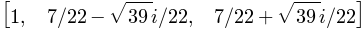

	 (and their complex modulus):


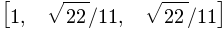

In [5]:
# BD3
coeff = [1,-18/11,9/11,-2/11]
print('Numerical roots via numpy:', np.roots( coeff ) ) 
print('\t (and their complex modulus):', np.abs( np.roots( coeff ) )  )
print('Exact roots via sympy:')
roots = solve(x**3 - 18/11*x**2 + 9/11*x -2/11, x, rational=True)
display( roots )
print('\t (and their complex modulus):')
display( [ sym.Abs(r) for r in roots ] )

#### BDF4

Numerical roots via numpy: [1.        +0.j         0.2692608 +0.49200027j 0.2692608 -0.49200027j
 0.38147841+0.j        ]
	 (and their complex modulus): [1.         0.56086152 0.56086152 0.38147841]
Exact roots via sympy:


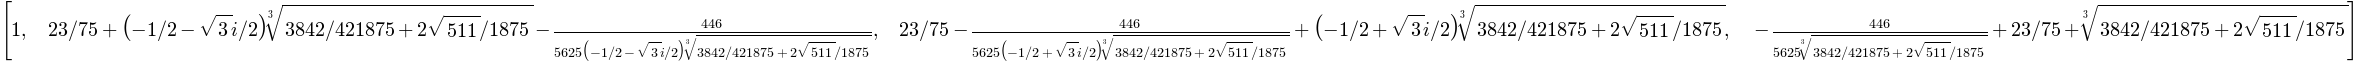

	 (and their complex modulus):


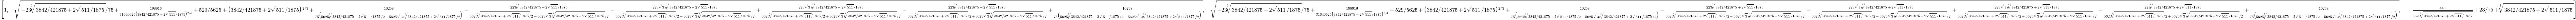

In [6]:
# BD4
coeff = [1,-48/25,36/25,-16/25,3/25]
print('Numerical roots via numpy:', np.roots( coeff ) ) 
print('\t (and their complex modulus):', np.abs( np.roots( coeff ) )  )
print('Exact roots via sympy:')
roots = solve(x**4 -48/25*x**3 + 36/25*x**2 - 16/25*x + 3/25, x, rational=True)
display( roots )
print('\t (and their complex modulus):')
display( [ sym.Abs(r) for r in roots ] )

### Let's make this more systematic and do **all** BD formulas

Let's do BDF7 and higher. One problem: you can't find these formulas on the web!! (why? because they are bad methods and no one uses them)

But we can derive it ourselves... these are the same as the forward finite difference methods we saw when we did **numerical differentiation** in ch 4.1

Again, it's hard to find these for higher-order, so we'll use the `findiff` python package which calculates them for us

In [ ]:
!pip install findiff  # see https://github.com/maroba/findiff
import findiff

#### Ask the package to find coefficients

First, let's do some checks: for 3rd order, we know what the coefficients are for BD3. Let's make sure they agree with what we find:

In [8]:
all_coeffs = findiff.coefficients(deriv=1, acc=3)
coeff = all_coeffs['forward']['coefficients']
print(coeff)
print("What we found before:")
print([1,-48/25,36/25,-16/25,3/25])
print("Which are the same if we divide by the leading coefficient:")
print( coeff/coeff[0] )

[-2.08333333  4.         -3.          1.33333333 -0.25      ]
What we found before:
[1, -1.92, 1.44, -0.64, 0.12]
Which are the same if we divide by the leading coefficient:
[ 1.   -1.92  1.44 -0.64  0.12]


#### Now do all BD Formulas
We saw above that the polynomials matched (well, up to a scaling, which we could either fix, or just ignore since it doesn't affect the *roots* of the polynomial)

The one slightly tricky part of the code below is that we know $\lambda=1$ is always a root (since these are consistent methods), and so we want to exclude its effects (now, if $\lambda=1$ is a double-root, that is a bad thing, so we'll only exclude the first instance of $\lambda=1$)

In [43]:
for order in range(1,13):
  all_coeffs = findiff.coefficients(deriv=1, acc=order)
  coeff = all_coeffs['forward']['coefficients']
  rts = np.roots( coeff )
  # find entry corresponding to lambda = 1
  index = np.argwhere( np.abs(rts-1) <= 1e-12 )[0] # only take 1st in case there are more
  rts = np.delete( rts, index )
  mx = np.max(np.abs(rts))
  print(f'For BD{order}, max modulus of root (other than lambda=1) is {mx:.2f}')

For BD1, max modulus of root (other than lambda=1) is 0.33
For BD2, max modulus of root (other than lambda=1) is 0.33
For BD3, max modulus of root (other than lambda=1) is 0.56
For BD4, max modulus of root (other than lambda=1) is 0.56
For BD5, max modulus of root (other than lambda=1) is 0.86
For BD6, max modulus of root (other than lambda=1) is 0.86
For BD7, max modulus of root (other than lambda=1) is 1.18
For BD8, max modulus of root (other than lambda=1) is 1.18
For BD9, max modulus of root (other than lambda=1) is 1.51
For BD10, max modulus of root (other than lambda=1) is 1.51
For BD11, max modulus of root (other than lambda=1) is 1.85
For BD12, max modulus of root (other than lambda=1) is 1.85


We conclude that for BD7 and higher, the max modulus of the root is $>1$, so these are **unstable**, which is why no one uses them

## Example of instability in action
Let's solve an IVP
$$y' = -k (y-\cos(t))$$
for $k=5$ and $0 \le t \le 20$ with $y(0)=0.2$.

There's a known true solution$$y(t)=\frac{y_0 - k^2}{k^2+1}e^{-kt} + k\frac{\sin(t) + k\cos(t)}{k^2+1}$$

t shape: (65,)
y shape: (1, 65)


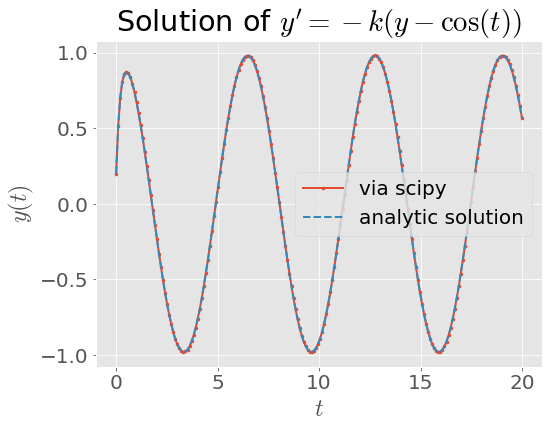

In [10]:
k  = 5 # a parameter
f  = lambda t,y: -k*( y - cos(t) )
y0 = .2;

# We have a known true solution
#   see https://github.com/cu-numcomp/numcomp-class/blob/master/DifferentialEquations.ipynb
y_true = lambda t : (y0 - k**2/(k**2+1) )*exp(-k*t) + k*(sin(t) + k*cos(t))/(k**2+1)


tspan = [0.0,20.0];

sol = solve_ivp(f,tspan,[y0],dense_output=True)
print("t shape:",sol.t.shape)
print("y shape:",sol.y.shape)

y_interpolated = sol.sol # a function!
t_points  = np.linspace(tspan[0],tspan[1],200)

plt.plot(t_points, y_interpolated(t_points)[0],".-",MarkerSize=5,label='via scipy')
plt.plot(t_points, y_true(t_points),"--",MarkerSize=5,label='analytic solution')
plt.xlabel("$t$"); plt.ylabel("$y(t)$");
plt.title("Solution of $y'=-k(y-\cos(t))$");
plt.legend();

### Examples of methods
We'll demonstrate stability/instability with **explicit** methods for simplicity, so mainly RK, Adams-Bashforth, Milne's method, and LIAF method from notes


#### RK4

In [11]:
def OneStepOfRK4(f,t,w,h):
  k1 = h*f(t,     w)
  k2 = h*f(t+h/2, w+k1/2)
  k3 = h*f(t+h/2, w+k2/2)
  k4 = h*f(t+h,   w+k3)
  return w + (k1+2*(k2+k3)+k4)/6
  
def RK4( f, tspan, y0, h=0.1, n=None, dense_output=False):
  if n == None:
    n = int( (tspan[1] - tspan[0])/h )+1
  t, h = np.linspace(tspan[0],tspan[1],num=n,retstep=True)
  w    = np.zeros(n)
  dydt = np.zeros(n)
  w[0] = y0
  dydt[0] = f(t[0],y0)
  for i in range(n-1):
    w[i+1] = OneStepOfRK4(f, t[i], w[i], h)
    dydt[i+1] = f(t[i+1],w[i+1])
  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(t,w,dydt)
    return t, w, sol
  else:  
    return t, w

#### Adams Bashforth

In [13]:
def getAdamsBashforthParameters( steps ):
  # Weights here: https://en.wikipedia.org/wiki/Linear_multistep_method#Adams%E2%80%93Bashforth_methods
  if steps==1:
    weights = [1]  # this is forward Euler
    denominator = 1
  elif steps==2:
    weights = [3,-1]
    denominator = 2
  elif steps==3:
    weights = [23,-16,5]
    denominator = 12
  elif steps==4:
    weights = [55,-59,37,-9]
    denominator = 24
  elif steps==5:
    weights = [1901,-2774,2616,-1274,251]
    denominator = 720
  else:
    raise ValueError("steps should be 1, 2, 3, 4 or 5")
  weights = np.flip( np.array(weights) ) # need to flip order to match
  return weights, denominator
  
def AdamsBashforth( f, tspan, y0, h=0.1, n=None, dense_output=False,steps=4,trueSolution = None):
  if n == None:
    n = int( (tspan[1] - tspan[0])/h )+1
  t, h = np.linspace(tspan[0],tspan[1],num=n,retstep=True)
  if steps < 0:
    raise ValueError("Need steps >= 0")
  w    = np.zeros(n)
  dydt = np.zeros(n)
  w[0] = y0
  dydt[0] = f(t[0],y0)

  weights, denominator = getAdamsBashforthParameters( steps )

  # use RK for the first few steps unless we cheat and use trueSolution
  if trueSolution is not None:
    for i in range(steps-1):
      w[i+1] = trueSolution( t[i+1] )
      dydt[i+1] = f(t[i+1],w[i+1])
  else:
    for i in range(steps-1):
      w[i+1] = OneStepOfRK4(f, t[i], w[i], h)
      dydt[i+1] = f(t[i+1],w[i+1])

  # The main loop:
  for i in range(steps-1,n-1):
    w[i+1]    = w[i] + h/denominator*np.dot(weights,dydt[i-steps+1:i+1])
    dydt[i+1] = f(t[i+1],w[i+1])

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(t,w,dydt)
    return t, w, sol
  else:  
    return t, w

#### Milne's method
This is weakly stable, not strongly stable

In [14]:
def MilnesMethod( f, tspan, y0, h=0.1, n=None, dense_output=False,trueSolution = None):
  if n == None:
    n = int( (tspan[1] - tspan[0])/h )+1
  t, h = np.linspace(tspan[0],tspan[1],num=n,retstep=True)
  w    = np.zeros(n)
  dydt = np.zeros(n)
  w[0] = y0
  dydt[0] = f(t[0],y0)

  steps = 4
  weights = np.array([2,-1,2])
  # use RK for the first few steps unless we cheat and use trueSolution
  if trueSolution is not None:
    for i in range(steps-1):
      w[i+1] = trueSolution( t[i+1] )
      dydt[i+1] = f(t[i+1],w[i+1])
  else:
    for i in range(steps-1):
      w[i+1] = OneStepOfRK4(f, t[i], w[i], h)
      dydt[i+1] = f(t[i+1],w[i+1])

  # The main loop:
  for i in range(steps-1,n-1):
    w[i+1]    = w[i-3] + 4*h/3*np.dot(weights,dydt[i-steps+2:i+1])
    dydt[i+1] = f(t[i+1],w[i+1])

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(t,w,dydt)
    return t, w, sol
  else:  
    return t, w

#### Define an ODE/IVP
And recreate Table 5.21 in the textbook to make sure we don't have any bugs in our implementation

In [15]:
# Another problem, in Example 5 in the book (ch 5.10)
def f(t,y):
  return -6*y+6
y0 = 2
y_true = lambda t : 1 + exp(-6*t)
tspan = [0.,1.]

print('Recreate Table 5.21 in Burden and Faires')
h = 0.1
tHist, wHist = MilnesMethod( f, tspan, y0, h,trueSolution = y_true)
print('via Milne Method\nTime\tw_i\t\t|y_i - w_i|')
for (i,w) in enumerate(wHist):
  print(f'{tHist[i]:.1f}\t{w:.7f}\t{np.abs(w-y_true(tHist[i])):.3e}')

tHist, wHist = AdamsBashforth( f, tspan, y0, h,trueSolution = y_true,steps=4)
print('via AB4\nTime\tw_i\t\t|y_i - w_i|')
for (i,w) in enumerate(wHist):
  print(f'{tHist[i]:.1f}\t{w:.7f}\t{np.abs(w-y_true(tHist[i])):.3e}')

Recreate Table 5.21 in Burden and Faires
via Milne Method
Time	w_i		|y_i - w_i|
0.0	2.0000000	0.000e+00
0.1	1.5488116	0.000e+00
0.2	1.3011942	0.000e+00
0.3	1.1652989	0.000e+00
0.4	1.0983785	7.661e-03
0.5	1.0417344	8.053e-03
0.6	1.0486438	2.132e-02
0.7	0.9634506	5.154e-02
0.8	1.1289977	1.208e-01
0.9	0.7282684	2.762e-01
1.0	1.6450917	6.426e-01
via AB4
Time	w_i		|y_i - w_i|
0.0	2.0000000	0.000e+00
0.1	1.5488116	0.000e+00
0.2	1.3011942	0.000e+00
0.3	1.1652989	0.000e+00
0.4	1.0996236	8.906e-03
0.5	1.0513350	1.548e-03
0.6	1.0425614	1.524e-02
0.7	1.0047990	1.020e-02
0.8	1.0359090	2.768e-02
0.9	0.9657936	3.872e-02
1.0	1.0709304	6.845e-02


#### Back to our original ODE/IVP
Note: in the live version of this demo, try running the `hList` cell for both problems. You'll see different behavior

In [20]:
k  = 5 # a parameter
def f(t,y):
  return -k*( y - cos(t) )
y0 = .2;
y_true = lambda t : (y0 - k**2/(k**2+1) )*exp(-k*t) + k*(sin(t) + k*cos(t))/(k**2+1)
tspan = [0.0,20.0];

Loop over stepsizes `h` to get an idea of convergence

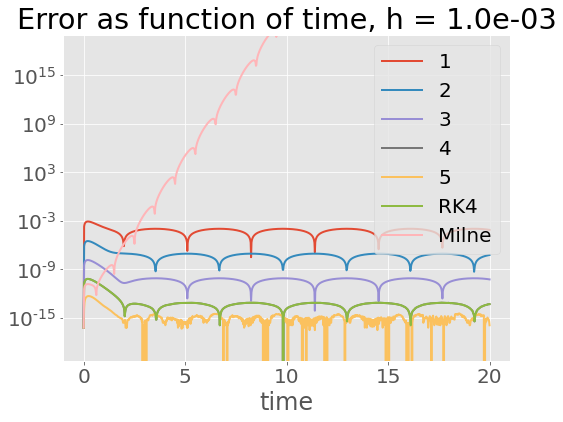

In [22]:
hList = np.logspace(-1,-3,8)
t  = np.linspace(tspan[0],tspan[1],1000)
ListOfMethods = [1,2,3,4,5,'RK4','Milne']
Results = {}
for method in ListOfMethods:
  errorList = []
  for h in hList:
    if method is 'RK4':
      tHist, wHist, y_interp = AdamsBashforth( f, tspan, y0, h=h, dense_output=True )
    elif method is 'Milne':
      #tHist, wHist, y_interp = MilnesMethod( f, tspan, y0, h=h, dense_output=True )
      tHist, wHist, y_interp = MilnesMethod( f, tspan, y0, h=h, dense_output=True,trueSolution = y_true )
    else:
      tHist, wHist, y_interp = AdamsBashforth( f, tspan, y0, h=h,
                                                dense_output=True, steps=method)
    e = y_true(t) - y_interp(t)
    err = np.linalg.norm( e, ord=np.inf)
    errorList.append( err )
    if h == hList[-1]:
      plt.semilogy(t,np.abs(e),label=method)
  Results[method] = errorList
plt.title(f'Error as function of time, h = {h:.1e}')
plt.legend()
plt.ylim(top=1e20)
plt.xlabel('time')
plt.show()

The error for Milne's error will go down if we take $h\to 0$  (excluding effects of finite-precision arithmetic), but you can see that errors get way worse over time, so this converges **theoretically** but is useless in practice

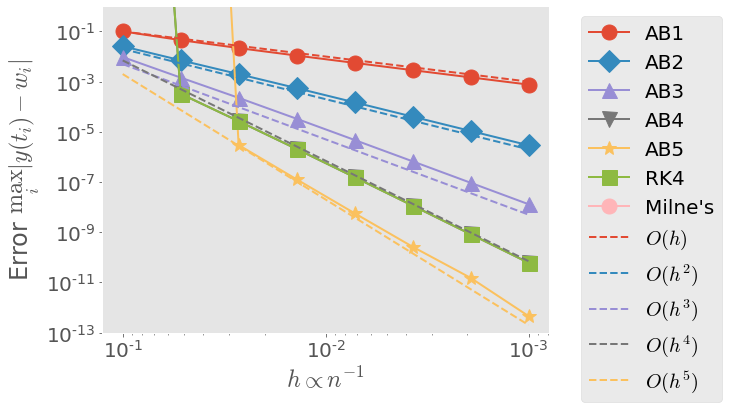

In [23]:
# Make the plots
import itertools
marker = itertools.cycle(('o', 'D', '^', 'v', '*','s')) # https://stackoverflow.com/a/13092467
# list of markers: https://matplotlib.org/api/markers_api.html
def makePlot():
  for method in ListOfMethods:
    if method is 'RK4':
      name = 'RK4'
    elif method is 'Milne':
      name = "Milne's"
    else:
      name = f'AB{method}'
    plt.loglog(hList, Results[method],".-",Marker=next(marker), MarkerSize=15,label=name);

  scaling = 10
  plt.loglog(hList, scaling*1e-1*hList,'--',label='$O(h)$');
  plt.loglog(hList, scaling*2e-1*hList**2,'--',label='$O(h^2)$');
  plt.loglog(hList, scaling*5e-1*hList**3,'--',label='$O(h^3)$');
  plt.loglog(hList, scaling*7e0*hList**4,'--',label='$O(h^4)$');
  plt.loglog(hList, scaling*2e1*hList**5,'--',label='$O(h^5)$');
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
  plt.grid()
  plt.gca().invert_xaxis() # think of it as 1/h
  plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
  # plt.xlabel('$h^{-1} \propto n$'); # if we plot 1/hList
  plt.xlabel('$h \propto n^{-1}$'); # if we plot hList and invert_xaxis
  
makePlot()
plt.ylim(top=1,bottom=1e-13)
plt.show()

Note: we don't expect AB5 to have $O(h^5)$ error, since we use RK4 (which is only $O(h^4)$) to start it off

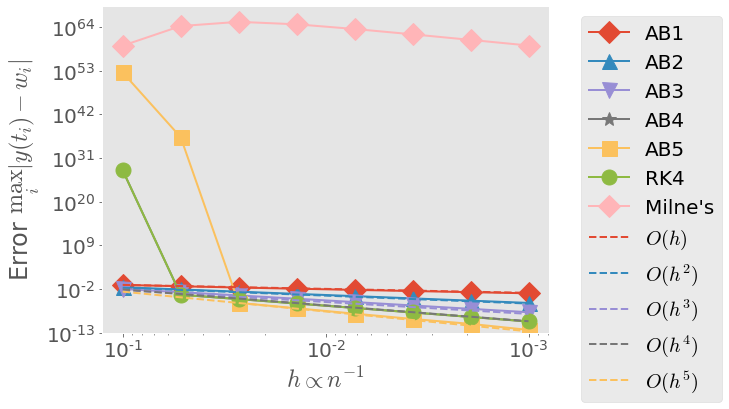

In [24]:
makePlot()
plt.ylim(bottom=1e-13)
plt.show()